In [1]:
import itertools

import pandas as pd

from edgedroid.models import *
import edgedroid.data as e_data
from gabriel_lego import LEGOTask, FrameResult
from tqdm.notebook import tqdm

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


def generate_latencies(mode: float, rho: float, min_bound: float = 0.0) -> Iterator[float]:
    prev_value = mode
    while True:
        prev_value = np.random.rayleigh(scale=(mode * (1 - rho)) + (prev_value * rho))
        yield min_bound + prev_value


def emulate_run(model: EdgeDroidModel, task: LEGOTask, rtt_s_iter: Iterator[float], desc: str | None = None):
    step_iter = tqdm(model.play_steps_emulated_time(), total=model.step_count + 1, desc=desc, leave=False)
    
    for model_step in step_iter:
        frame_timings: Optional[FrameTimings] = None
        prev_result: Optional[FrameResult] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if prev_result != FrameResult.SUCCESS:
                    raise Exception(prev_result)
                break
            prev_result = task.submit_frame(model_frame.frame_data)
            
            rtt = next(rtt_s_iter)
            frame_timings = FrameTimings(rtt * 0.9, rtt * 0.1)
            

emulate_run(model, task, generate_latencies(3.2, rho=.2, min_bound=0.1))
model.model_step_metrics()

  0%|          | 0/6 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,2.100190,0.000000,2.100190,2.100190,0.000000,1
1,2.049848,5.391399,9.227795,3.836396,1.786548,2
2,5.942207,6.031355,14.806253,8.774898,2.832690,3
3,1.958650,6.628337,8.969121,2.340785,0.382135,4
4,1.226289,5.431671,9.241831,3.810160,2.583871,4
5,1.866284,6.013001,10.426351,4.413350,2.547066,3


In [3]:
import itertools as it

trace = "square00"
truncate = 50
reps_per_model = 20
rep_offset = 10

timing_models = {
    "curve-high": lambda : MultiCurveFittingExecutionTimeModel(neuroticism=1.0),
    "curve-low": lambda : MultiCurveFittingExecutionTimeModel(neuroticism=0.0),
    "legacy": lambda : LegacyModel(),
    "first-order": lambda : FirstOrderETM(),
    "first-order-median": lambda : FirstOrderAggregateETM(np.median)
}

min_bound = 0.042 # 24FPS

rho_vals = (
    0.0, 
    0.25, 
    0.5,
    0.6,
    0.7,
    0.8,
)
sigma_vals = (
    0.1, 
    0.2, 
    0.4, 
    0.8, 
    1.6, 
    # 3.2
)

dfs = deque()

params_iter = tqdm(list(it.product(
    timing_models.items(),
    range(rep_offset, reps_per_model + rep_offset),
    rho_vals,
    sigma_vals
)), desc="Parameter combinations")
for (model_name, model_constructor), rep, rho, sigma in params_iter:
    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=ZeroWaitSamplingPolicy.from_default_data(),
        timing_model=model_constructor()
    )

    task = LEGOTask(e_data.load_default_task(trace, truncate=truncate))
    
    desc = f"{model_name} {rho=} {sigma=} ({rep + 1}/{reps_per_model + rep_offset})"
    emulate_run(model, task, generate_latencies(sigma, rho, min_bound=min_bound), desc=desc)
    
    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["rho"] = rho
    df["sigma"] = sigma
    
    dfs.append(df)
    
data = pd.concat(dfs)
data.to_csv("./per_frame_delay_new_runs.csv")
data

Parameter combinations:   0%|          | 0/3000 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma
step_number,,,,,,,,,,
0,0.269125,0.000000,0.269125,0.269125,0.000000,1,curve-high,10,0.0,0.1
1,0.265742,5.051648,5.368690,0.317043,0.051301,30,curve-high,10,0.0,0.1
2,0.093887,5.068235,5.171355,0.103121,0.009234,34,curve-high,10,0.0,0.1
3,0.055775,4.988139,5.134375,0.146236,0.090461,32,curve-high,10,0.0,0.1
4,0.189930,4.633764,4.977466,0.343702,0.153772,25,curve-high,10,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...
46,3.317633,5.230947,8.754003,3.523056,0.205423,4,first-order-median,29,0.8,1.6
47,3.281499,5.230947,8.767749,3.536802,0.255302,7,first-order-median,29,0.8,1.6
48,2.597826,5.230947,10.544430,5.313483,2.715657,2,first-order-median,29,0.8,1.6


,model,rep,rho,sigma,step_duration
0,curve-high,0,0.0,0.1,213.669584
1,curve-high,0,0.0,0.2,235.053415
2,curve-high,0,0.0,0.4,303.845079
3,curve-high,0,0.0,0.8,356.731061
4,curve-high,0,0.0,1.6,474.719026
...,...,...,...,...,...
895,legacy,9,0.5,0.2,236.459827
896,legacy,9,0.5,0.4,272.205988
897,legacy,9,0.5,0.8,317.271544
898,legacy,9,0.5,1.6,463.070794


In [73]:
data = pd.concat((pd.read_csv("./per_frame_delay.csv"), pd.read_csv("./per_frame_delay_high_corr.csv"), pd.read_csv("./per_frame_delay_new_runs.csv")))
models = pd.CategoricalDtype(["curve-low", "curve-high", "legacy", "first-order", "first-order-median"], ordered=False)
data["model"] = data["model"].astype(models)
data = data[data["rho"] < 0.8]
data = data[data["sigma"] < 3.2]

rho_sigma_dtype = pd.CategoricalDtype(map(lambda t: f"{t[0]} {t[1]}", itertools.product(sorted(data["rho"].unique()), sorted(data["sigma"].unique()))), ordered=True)

data["rho"] = data["rho"].astype("category")
data["sigma"] = data["sigma"].astype("category")


data["rho_sigma"] = data[["rho", "sigma"]].apply(func=lambda row: f"{row.rho} {row.sigma}", axis=1).astype(rho_sigma_dtype)
data



,step_number,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma,rho_sigma
0,0,0.143041,0.000000,0.143041,0.143041,0.000000,1,curve-high,0,0.0,0.1,0.0 0.1
1,1,0.201519,5.004304,5.333957,0.329653,0.128135,33,curve-high,0,0.0,0.1,0.0 0.1
2,2,0.143975,5.072477,5.222050,0.149573,0.005599,32,curve-high,0,0.0,0.1,0.0 0.1
3,3,0.067107,5.006894,5.083496,0.076602,0.009495,27,curve-high,0,0.0,0.1,0.0 0.1
4,4,0.140907,4.585061,4.731451,0.146390,0.005483,33,curve-high,0,0.0,0.1,0.0 0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
152740,46,8.462197,5.230947,15.987065,10.756118,2.293921,2,first-order-median,29,0.7,1.6,0.7 1.6
152741,47,9.192778,5.230947,19.018868,13.787921,4.595142,2,first-order-median,29,0.7,1.6,0.7 1.6
152742,48,18.223608,5.230947,26.846506,21.615559,3.391951,2,first-order-median,29,0.7,1.6,0.7 1.6
152743,49,7.776005,5.230947,19.948691,14.717744,6.941738,2,first-order-median,29,0.7,1.6,0.7 1.6


In [74]:
total_durations = data.groupby(["model", "rep", "rho", "sigma", "rho_sigma"], observed=True)["step_duration"].sum().reset_index()
total_durations

,model,rep,rho,sigma,rho_sigma,step_duration
0,curve-low,0,0.0,0.1,0.0 0.1,194.621116
1,curve-low,0,0.0,0.2,0.0 0.2,236.042004
2,curve-low,0,0.0,0.4,0.0 0.4,293.955499
3,curve-low,0,0.0,0.8,0.0 0.8,341.913779
4,curve-low,0,0.0,1.6,0.0 1.6,454.097454
...,...,...,...,...,...,...
3745,first-order-median,29,0.7,0.1,0.7 0.1,315.987521
3746,first-order-median,29,0.7,0.2,0.7 0.2,351.020696
3747,first-order-median,29,0.7,0.4,0.7 0.4,542.513811
3748,first-order-median,29,0.7,0.8,0.7 0.8,513.347760


mean duration


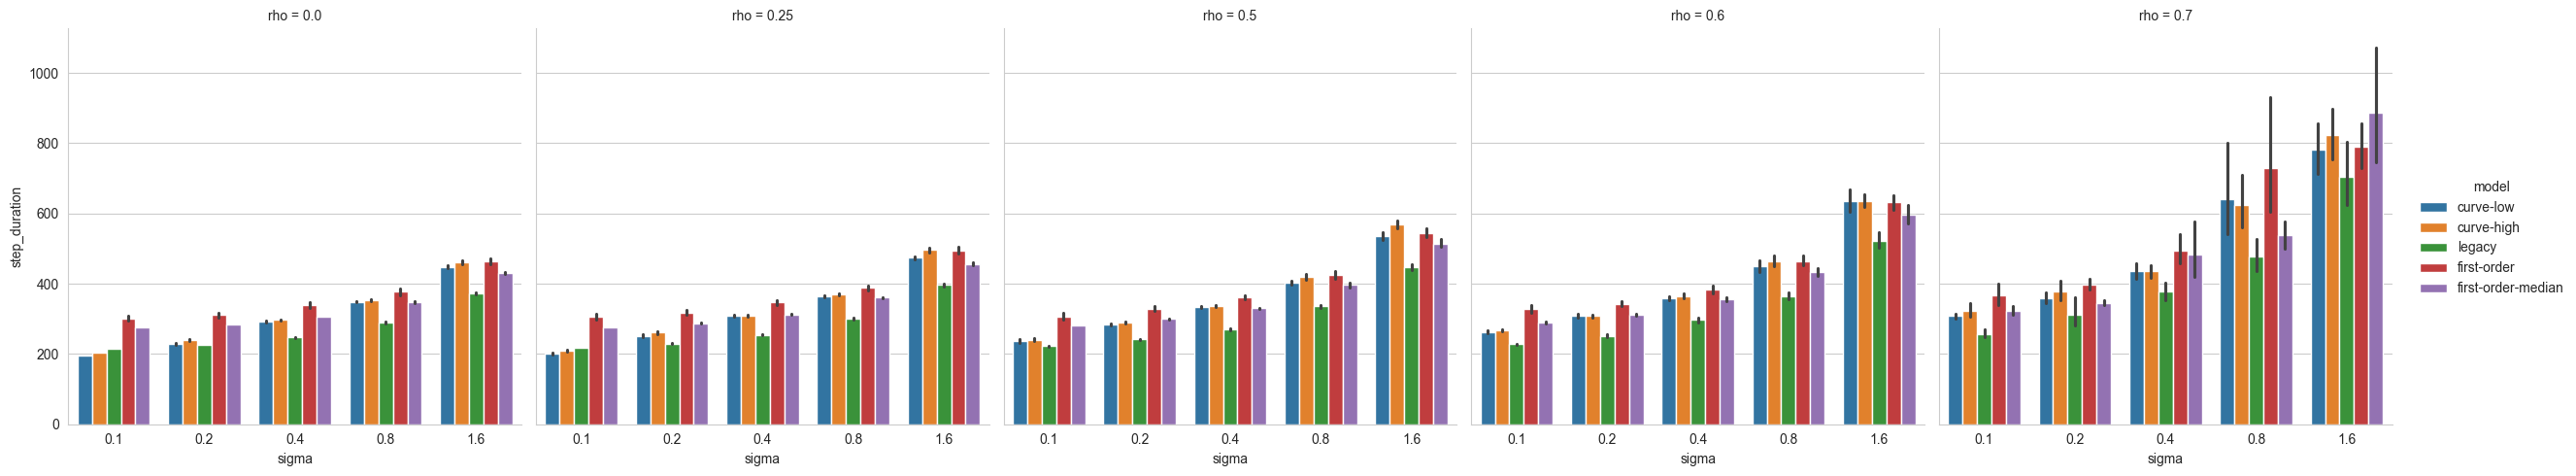

In [75]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, hue="model", y="step_duration", x="sigma", col="rho")
# fg.set(yscale="log")
plt.show()

# push correlation higher

mean number of frames


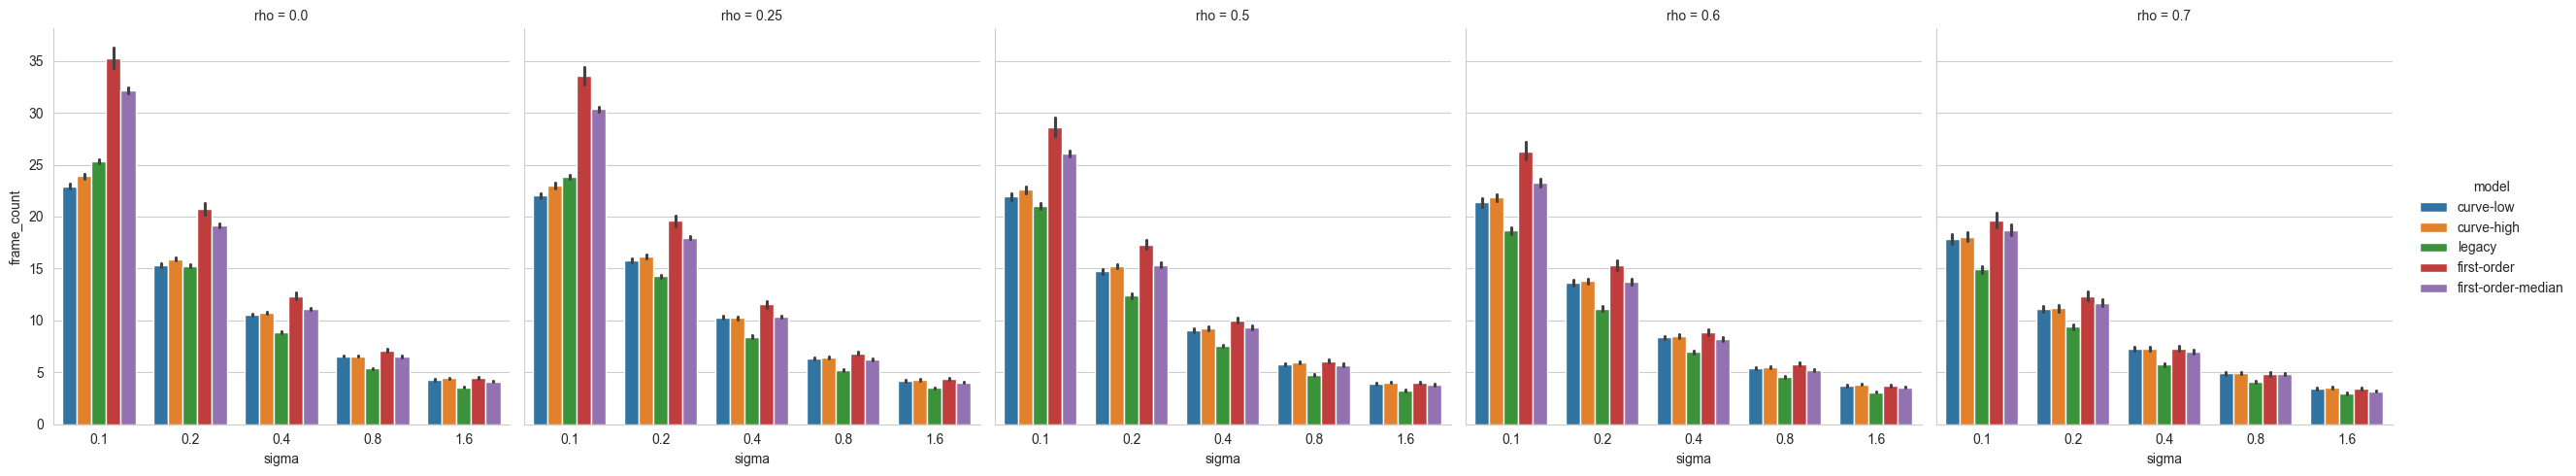

In [61]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, y="frame_count", hue="model", x="sigma", col="rho")
plt.show()

mean TTF


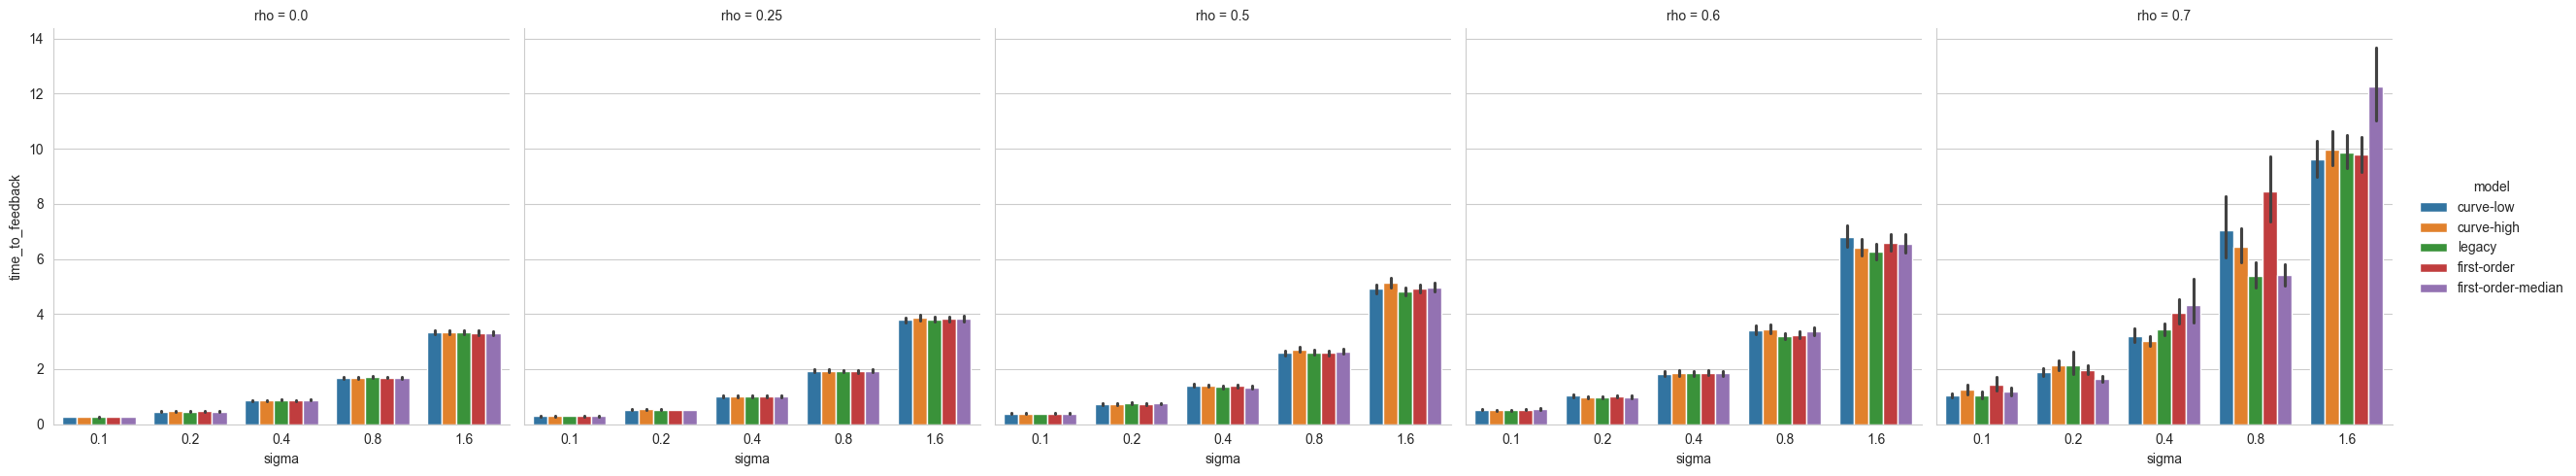

In [69]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, hue="model", y="time_to_feedback", x="sigma", col="rho")
plt.show()

mean wait time


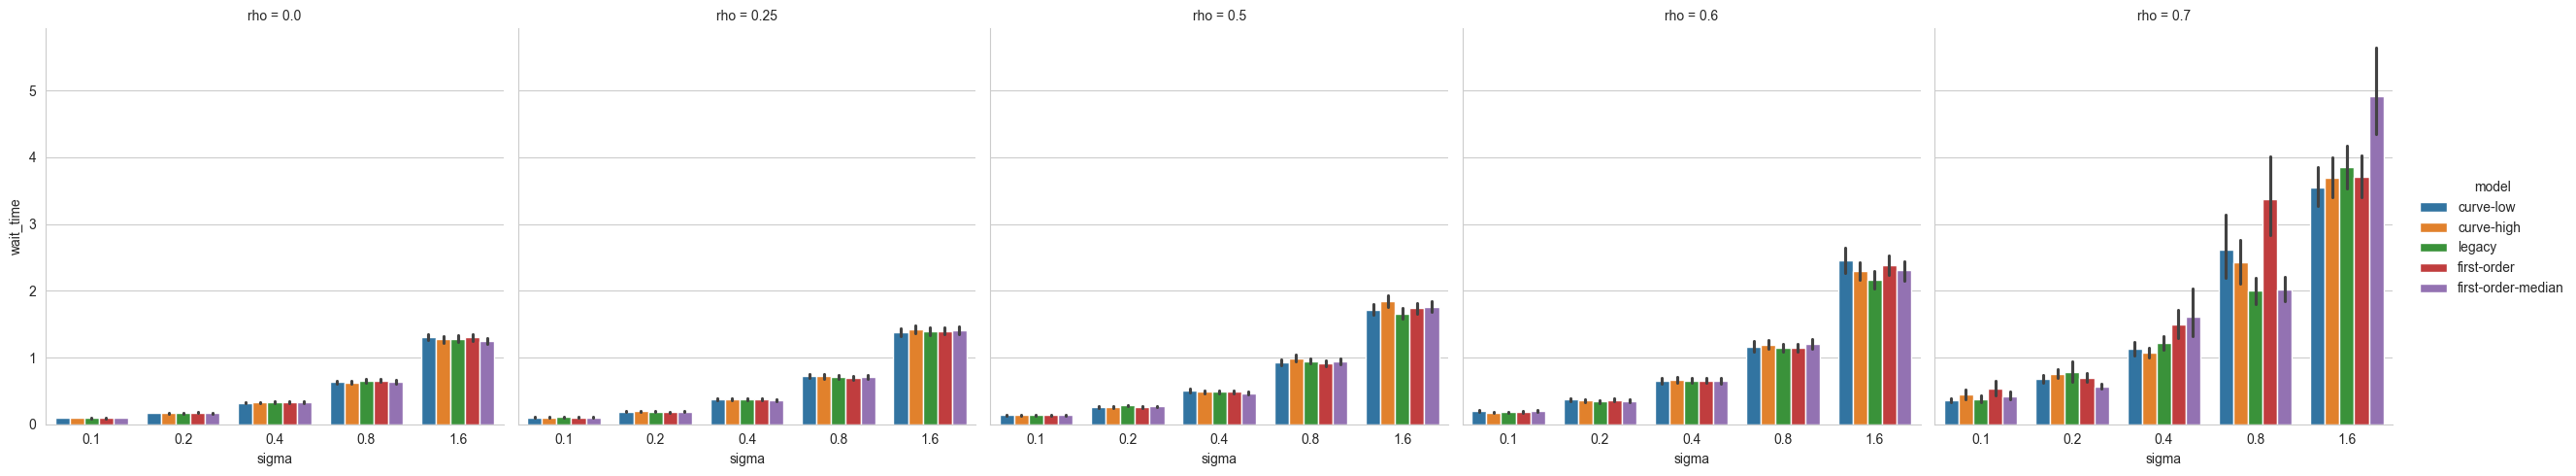

In [68]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, hue="model", y="wait_time", x="sigma", col="rho")
plt.show()

mean last frame rtt


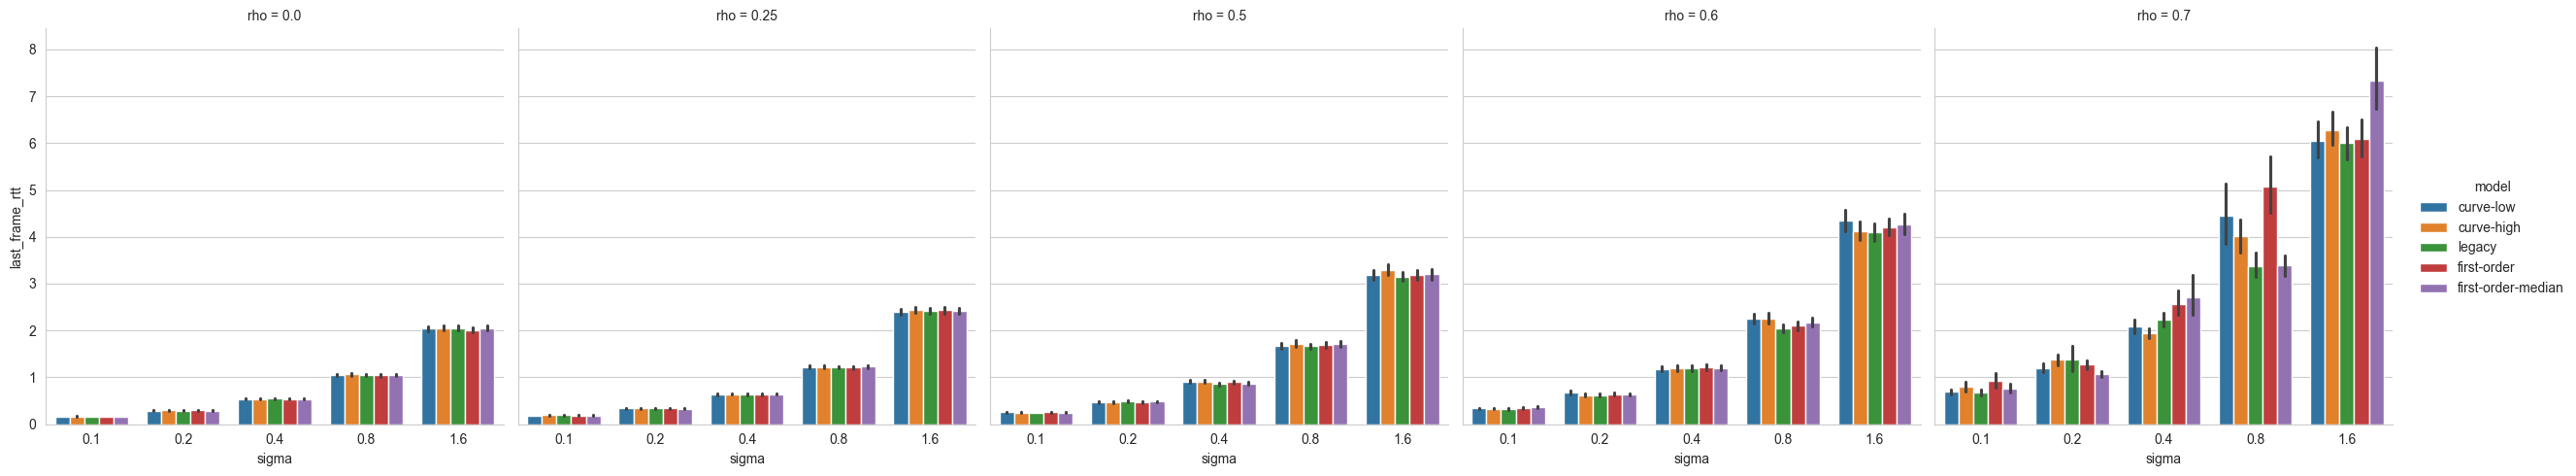

In [67]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, hue="model", y="last_frame_rtt", x="sigma", col="rho")
plt.show()